In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Load required libraries and datasets

In [3]:
# Load datasets
transaction_data = pd.read_excel("data/QVI_transaction_data.xlsx")
customer_data = pd.read_csv("data/QVI_purchase_behaviour.csv")

print("Data loaded successfully!")

Data loaded successfully!


In [4]:
transaction_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


# Exploratory Data Analysis

In [5]:
# Examining transaction data
print("\n=== EXAMINING TRANSACTION DATA ===")
print("Transaction data shape:", transaction_data.shape)
print("\nTransaction data info:")
print(transaction_data.info())
print("\nFirst few rows:")
print(transaction_data.head())


=== EXAMINING TRANSACTION DATA ===
Transaction data shape: (264836, 8)

Transaction data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB
None

First few rows:
    DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
0  43390          1            1000       1         5   
1  43599          1            1307     348        66   
2  43605          1            1343     383        61   
3  43329          2  

In [6]:
# Convert DATE to proper date format
# CSV and Excel integer dates begin on 30 Dec 1899
transaction_data['DATE'] = pd.to_datetime(transaction_data['DATE'], origin='1899-12-30', unit='D')

print("\nDate conversion completed!")
print("Date range:", transaction_data['DATE'].min(), "to", transaction_data['DATE'].max())


Date conversion completed!
Date range: 2018-07-01 00:00:00 to 2019-06-30 00:00:00


In [7]:
# Examine PROD_NAME
print("\n=== EXAMINING PROD_NAME ===")
print("Unique products:", transaction_data['PROD_NAME'].nunique())
print("\nSample product names:")
print(transaction_data['PROD_NAME'].head(10).tolist())


=== EXAMINING PROD_NAME ===
Unique products: 114

Sample product names:
['Natural Chip        Compny SeaSalt175g', 'CCs Nacho Cheese    175g', 'Smiths Crinkle Cut  Chips Chicken 170g', 'Smiths Chip Thinly  S/Cream&Onion 175g', 'Kettle Tortilla ChpsHny&Jlpno Chili 150g', 'Old El Paso Salsa   Dip Tomato Mild 300g', 'Smiths Crinkle Chips Salt & Vinegar 330g', 'Grain Waves         Sweet Chilli 210g', 'Doritos Corn Chip Mexican Jalapeno 150g', 'Grain Waves Sour    Cream&Chives 210G']


In [8]:
# Examine words in PROD_NAME to check for incorrect entries
product_words = []
for prod_name in transaction_data['PROD_NAME'].unique():
    words = prod_name.split()
    product_words.extend(words)

product_words_df = pd.DataFrame(product_words, columns=['words'])

In [9]:
# Remove digits
product_words_clean = product_words_df[~product_words_df['words'].str.contains(r'\d', na=False)]

# Remove special characters
product_words_clean = product_words_clean[~product_words_clean['words'].str.contains(r'[&@#$%^*()+=\[\]{}|\\:";\'<>?,./]', na=False)]

# Count word frequency
word_frequency = product_words_clean['words'].value_counts()
print("\nMost common words in product names:")
print(word_frequency.head(10))


Most common words in product names:
words
Chips       21
Smiths      16
Crinkle     14
Cut         14
Kettle      13
Salt        12
Cheese      12
Original    10
Doritos      9
Chip         9
Name: count, dtype: int64


In [10]:
# Remove salsa products
transaction_data['SALSA'] = transaction_data['PROD_NAME'].str.lower().str.contains('salsa', na=False)
transaction_data = transaction_data[transaction_data['SALSA'] == False].drop('SALSA', axis=1)

print(f"\nAfter removing salsa products: {len(transaction_data)} transactions remain")


After removing salsa products: 246742 transactions remain


In [11]:
# Check for nulls and outliers
print("\n=== CHECKING FOR NULLS AND OUTLIERS ===")
print("Null values per column:")
print(transaction_data.isnull().sum())
print("\nSummary statistics:")
print(transaction_data.describe())


=== CHECKING FOR NULLS AND OUTLIERS ===
Null values per column:
DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
dtype: int64

Summary statistics:
                                DATE      STORE_NBR  LYLTY_CARD_NBR  \
count                         246742  246742.000000    2.467420e+05   
mean   2018-12-30 01:19:01.211467520     135.051098    1.355310e+05   
min              2018-07-01 00:00:00       1.000000    1.000000e+03   
25%              2018-09-30 00:00:00      70.000000    7.001500e+04   
50%              2018-12-30 00:00:00     130.000000    1.303670e+05   
75%              2019-03-31 00:00:00     203.000000    2.030840e+05   
max              2019-06-30 00:00:00     272.000000    2.373711e+06   
std                              NaN      76.787096    8.071528e+04   

             TXN_ID       PROD_NBR       PROD_QTY      TOT_SALES  
count  2.467420e+05  246742.000000

In [12]:
# Investigate outlier in product quantity
print("\n=== INVESTIGATING QUANTITY OUTLIERS ===")
max_qty = transaction_data['PROD_QTY'].max()
print(f"Maximum quantity: {max_qty}")


=== INVESTIGATING QUANTITY OUTLIERS ===
Maximum quantity: 200


In [13]:
# Filter transactions with 200+ packets
high_qty_transactions = transaction_data[transaction_data['PROD_QTY'] >= 200]
print(f"\nTransactions with 200+ packets:")
print(high_qty_transactions[['LYLTY_CARD_NBR', 'DATE', 'PROD_NAME', 'PROD_QTY', 'TOT_SALES']])


Transactions with 200+ packets:
       LYLTY_CARD_NBR       DATE                         PROD_NAME  PROD_QTY  \
69762          226000 2018-08-19  Dorito Corn Chp     Supreme 380g       200   
69763          226000 2019-05-20  Dorito Corn Chp     Supreme 380g       200   

       TOT_SALES  
69762      650.0  
69763      650.0  


In [14]:
# Check other transactions by the same customer
if len(high_qty_transactions) > 0:
    outlier_customer = high_qty_transactions['LYLTY_CARD_NBR'].iloc[0]
    customer_transactions = transaction_data[transaction_data['LYLTY_CARD_NBR'] == outlier_customer]
    print(f"\nAll transactions by customer {outlier_customer}:")
    print(customer_transactions[['DATE', 'PROD_NAME', 'PROD_QTY', 'TOT_SALES']])
    
    # Remove this customer from analysis
    transaction_data = transaction_data[transaction_data['LYLTY_CARD_NBR'] != outlier_customer]
    print(f"\nAfter removing outlier customer: {len(transaction_data)} transactions remain")


All transactions by customer 226000:
            DATE                         PROD_NAME  PROD_QTY  TOT_SALES
69762 2018-08-19  Dorito Corn Chp     Supreme 380g       200      650.0
69763 2019-05-20  Dorito Corn Chp     Supreme 380g       200      650.0

After removing outlier customer: 246740 transactions remain


In [15]:
# Re-examine transaction data
print("\nRe-examining data after outlier removal:")
print(transaction_data['PROD_QTY'].describe())


Re-examining data after outlier removal:
count    246740.000000
mean          1.906456
std           0.342499
min           1.000000
25%           2.000000
50%           2.000000
75%           2.000000
max           5.000000
Name: PROD_QTY, dtype: float64


In [16]:
# Count transactions by date
print("\n=== ANALYZING TRANSACTIONS OVER TIME ===")
transactions_by_day = transaction_data.groupby('DATE').size().reset_index(name='N')
print(f"Number of unique dates: {len(transactions_by_day)}")


=== ANALYZING TRANSACTIONS OVER TIME ===
Number of unique dates: 364


In [17]:
# Create complete date sequence
date_range = pd.date_range(start='2018-07-01', end='2019-06-30', freq='D')
complete_dates = pd.DataFrame(date_range, columns=['DATE'])

In [18]:
# Join with transaction counts
transactions_by_day = complete_dates.merge(transactions_by_day, on='DATE', how='left').fillna(0)

print(f"Complete date range: {len(complete_dates)} days")

Complete date range: 365 days


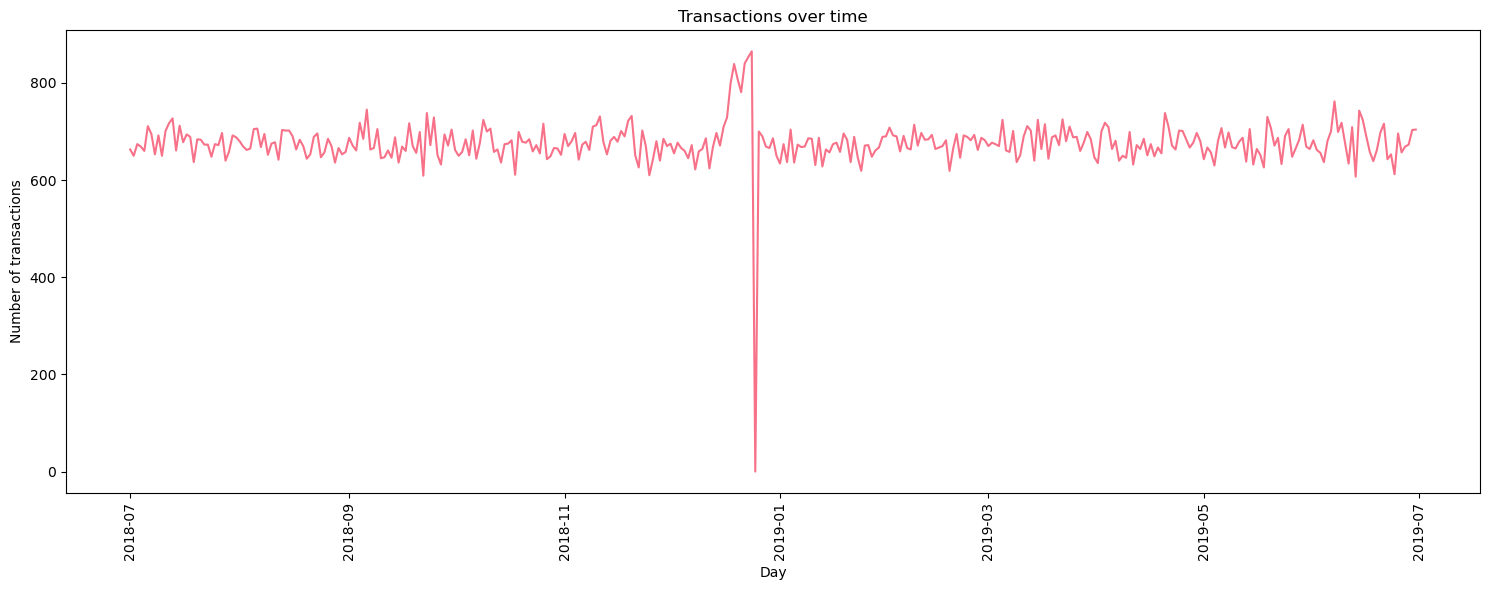

In [19]:
# Plot transactions over time
plt.figure(figsize=(15, 6))
plt.plot(transactions_by_day['DATE'], transactions_by_day['N'])
plt.title('Transactions over time')
plt.xlabel('Day')
plt.ylabel('Number of transactions')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

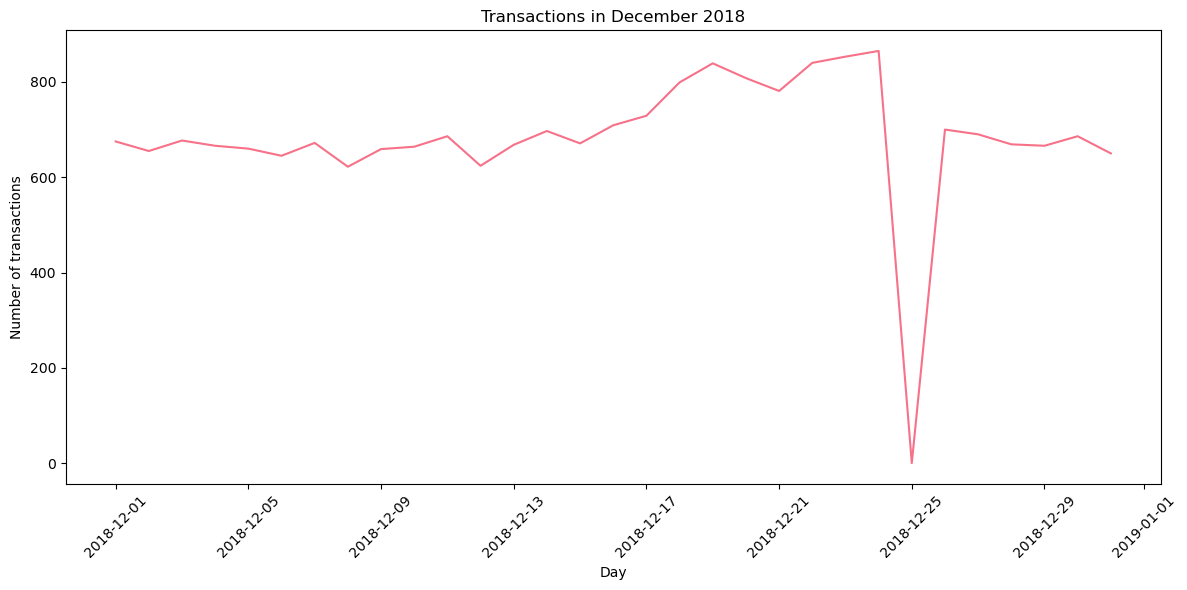

In [20]:
# Filter to December for detailed view
december_data = transactions_by_day[
    (transactions_by_day['DATE'] >= '2018-12-01') & 
    (transactions_by_day['DATE'] <= '2018-12-31')
]

plt.figure(figsize=(12, 6))
plt.plot(december_data['DATE'], december_data['N'])
plt.title('Transactions in December 2018')
plt.xlabel('Day')
plt.ylabel('Number of transactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Creating pack size feature

In [21]:
transaction_data['PACK_SIZE'] = transaction_data['PROD_NAME'].str.extract(r'(\d+)').astype(float)

# Check pack sizes
pack_size_counts = transaction_data['PACK_SIZE'].value_counts().sort_index()
print("Pack sizes found:")
print(pack_size_counts)


Pack sizes found:
PACK_SIZE
70.0      1507
90.0      3008
110.0    22387
125.0     1454
134.0    25102
135.0     3257
150.0    40203
160.0     2970
165.0    15297
170.0    19983
175.0    66390
180.0     1468
190.0     2995
200.0     4473
210.0     6272
220.0     1564
250.0     3169
270.0     6285
330.0    12540
380.0     6416
Name: count, dtype: int64


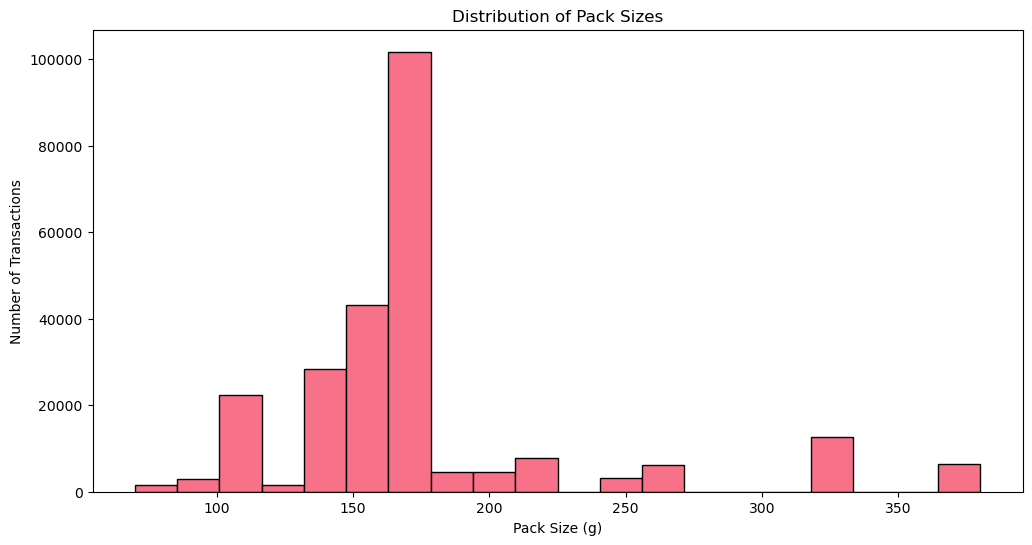

In [22]:
# Plot pack size histogram
plt.figure(figsize=(12, 6))
plt.hist(transaction_data['PACK_SIZE'].dropna(), bins=20, edgecolor='black')
plt.title('Distribution of Pack Sizes')
plt.xlabel('Pack Size (g)')
plt.ylabel('Number of Transactions')
plt.show()

In [23]:
# Create brand feature
print("\n=== CREATING BRAND FEATURE ===")
transaction_data['BRAND'] = transaction_data['PROD_NAME'].str.split().str[0]

# Check brands
brand_counts = transaction_data['BRAND'].value_counts()
print("Top brands:")
print(brand_counts.head(10))


=== CREATING BRAND FEATURE ===
Top brands:
BRAND
Kettle       41288
Smiths       27390
Pringles     25102
Doritos      22041
Thins        14075
RRD          11894
Infuzions    11057
WW           10320
Cobs          9693
Tostitos      9471
Name: count, dtype: int64


In [24]:
# Clean brand names
print("\n=== CLEANING BRAND NAMES ===")
transaction_data.loc[transaction_data['BRAND'] == 'RED', 'BRAND'] = 'RRD'

# Check cleaned brands
brand_counts_clean = transaction_data['BRAND'].value_counts()
print("Brands after cleaning:")
print(brand_counts_clean.head(10))


=== CLEANING BRAND NAMES ===
Brands after cleaning:
BRAND
Kettle       41288
Smiths       27390
Pringles     25102
Doritos      22041
Thins        14075
RRD          11894
Infuzions    11057
WW           10320
Cobs          9693
Tostitos      9471
Name: count, dtype: int64


# Examining Customer Data

In [25]:
print("\n=== EXAMINING CUSTOMER DATA ===")
print("Customer data shape:", customer_data.shape)
print("\nCustomer data info:")
print(customer_data.info())
print("\nCustomer data summary:")
print(customer_data.describe(include='all'))

# Merge datasets
data = transaction_data.merge(customer_data, on='LYLTY_CARD_NBR', how='left')
print(f"\nMerged data shape: {data.shape}")
print(f"Original transaction data shape: {transaction_data.shape}")

# Check for unmatched customers
print(f"Null values in merged data:")
print(data.isnull().sum())


=== EXAMINING CUSTOMER DATA ===
Customer data shape: (72637, 3)

Customer data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB
None

Customer data summary:
        LYLTY_CARD_NBR LIFESTAGE PREMIUM_CUSTOMER
count     7.263700e+04     72637            72637
unique             NaN         7                3
top                NaN  RETIREES       Mainstream
freq               NaN     14805            29245
mean      1.361859e+05       NaN              NaN
std       8.989293e+04       NaN              NaN
min       1.000000e+03       NaN              NaN
25%       6.620200e+04       NaN              NaN
50%       1.340400e+05       NaN              N

# Data Analysis on Customer Segments


=== CUSTOMER SEGMENT ANALYSIS ===


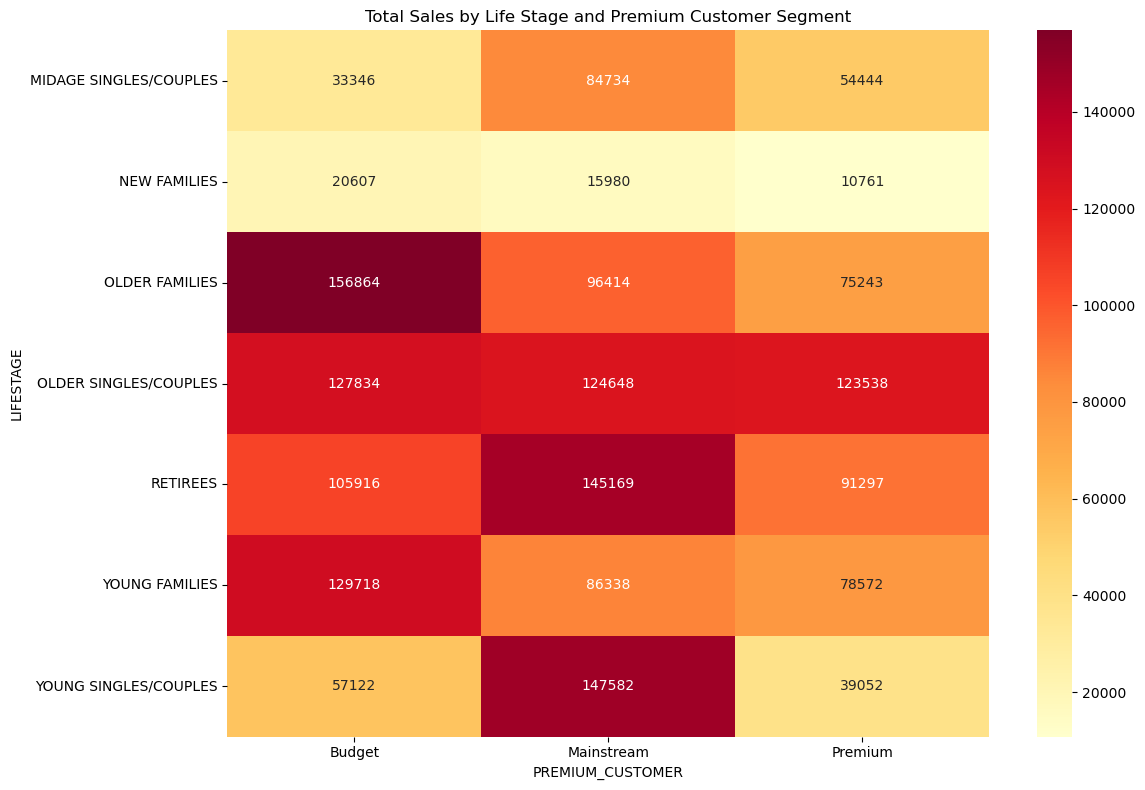

In [26]:
print("\n=== CUSTOMER SEGMENT ANALYSIS ===")

# Total sales by LIFESTAGE and PREMIUM_CUSTOMER
sales_summary = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].sum().reset_index()
sales_pivot = sales_summary.pivot(index='LIFESTAGE', columns='PREMIUM_CUSTOMER', values='TOT_SALES')

plt.figure(figsize=(12, 8))
sns.heatmap(sales_pivot, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('Total Sales by Life Stage and Premium Customer Segment')
plt.tight_layout()
plt.show()

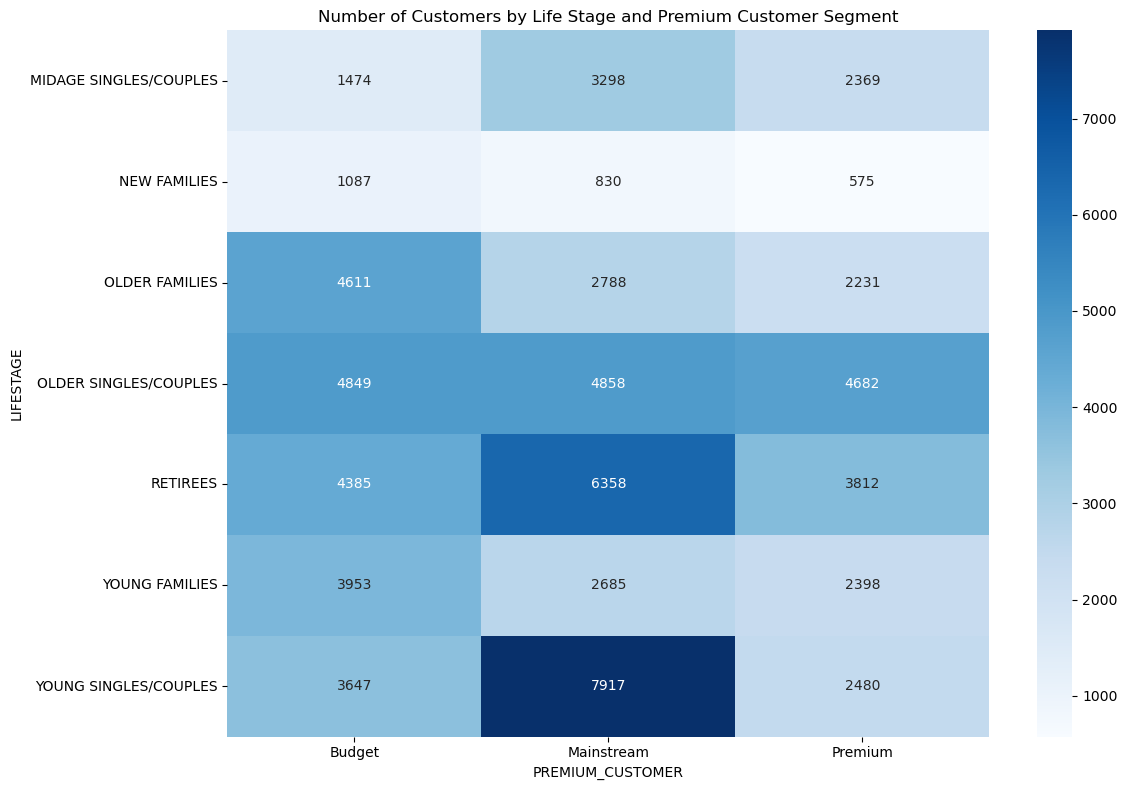

In [27]:
# Number of customers by segment
customer_counts = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['LYLTY_CARD_NBR'].nunique().reset_index()
customer_pivot = customer_counts.pivot(index='LIFESTAGE', columns='PREMIUM_CUSTOMER', values='LYLTY_CARD_NBR')

plt.figure(figsize=(12, 8))
sns.heatmap(customer_pivot, annot=True, fmt='d', cmap='Blues')
plt.title('Number of Customers by Life Stage and Premium Customer Segment')
plt.tight_layout()
plt.show()

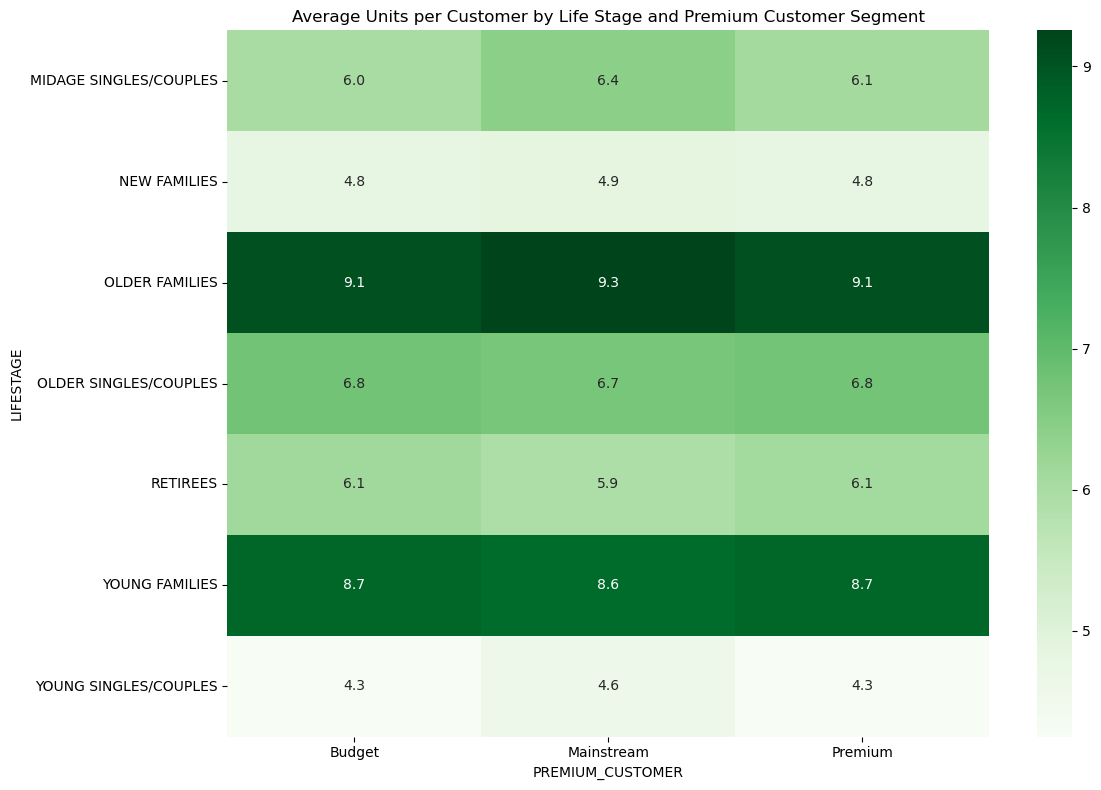

In [28]:
# Average units per customer
units_per_customer = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).agg({
    'PROD_QTY': 'sum',
    'LYLTY_CARD_NBR': 'nunique'
}).reset_index()
units_per_customer['AVG_UNITS'] = units_per_customer['PROD_QTY'] / units_per_customer['LYLTY_CARD_NBR']

units_pivot = units_per_customer.pivot(index='LIFESTAGE', columns='PREMIUM_CUSTOMER', values='AVG_UNITS')

plt.figure(figsize=(12, 8))
sns.heatmap(units_pivot, annot=True, fmt='.1f', cmap='Greens')
plt.title('Average Units per Customer by Life Stage and Premium Customer Segment')
plt.tight_layout()
plt.show()

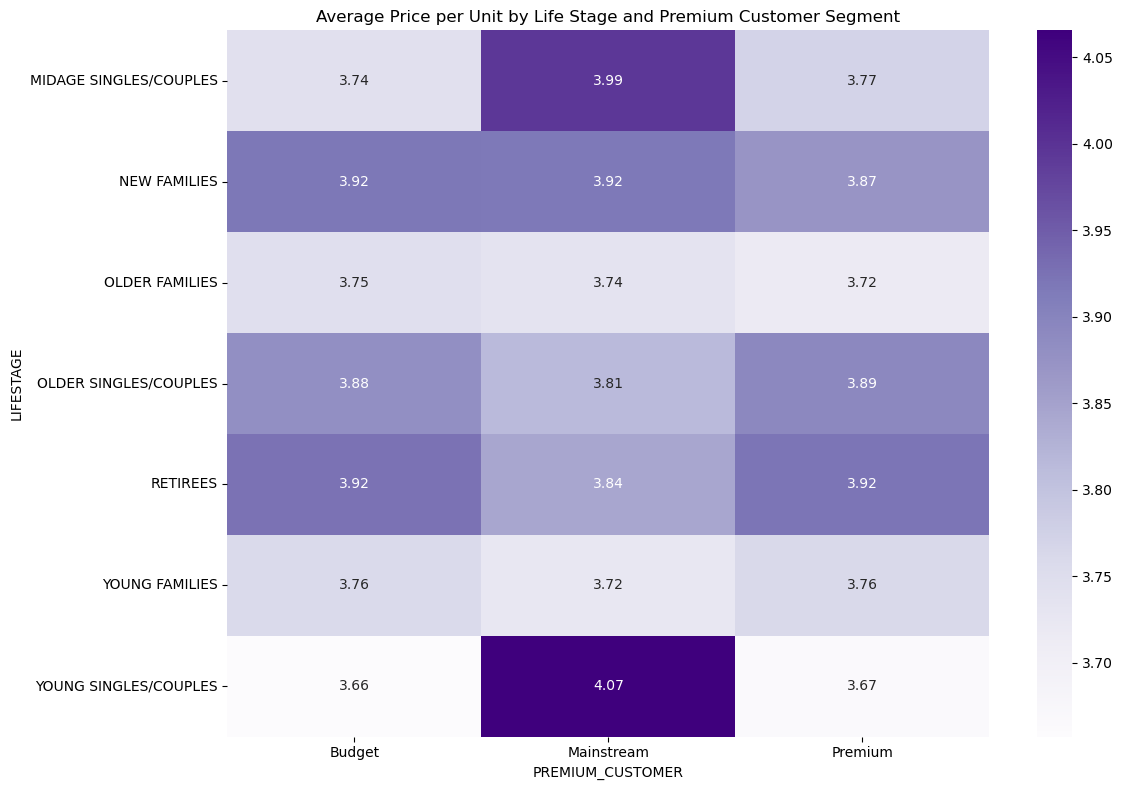

In [29]:
# Average price per unit
data['PRICE_PER_UNIT'] = data['TOT_SALES'] / data['PROD_QTY']
price_summary = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['PRICE_PER_UNIT'].mean().reset_index()
price_pivot = price_summary.pivot(index='LIFESTAGE', columns='PREMIUM_CUSTOMER', values='PRICE_PER_UNIT')

plt.figure(figsize=(12, 8))
sns.heatmap(price_pivot, annot=True, fmt='.2f', cmap='Purples')
plt.title('Average Price per Unit by Life Stage and Premium Customer Segment')
plt.tight_layout()
plt.show()

In [30]:
# Statistical test between mainstream vs others
print("\n=== STATISTICAL TESTING ===")

# Filter data for young and midage singles and couples
young_midage = data[data['LIFESTAGE'].isin(['YOUNG SINGLES/COUPLES', 'MIDAGE SINGLES/COUPLES'])]

mainstream_prices = young_midage[young_midage['PREMIUM_CUSTOMER'] == 'Mainstream']['PRICE_PER_UNIT']
other_prices = young_midage[young_midage['PREMIUM_CUSTOMER'].isin(['Budget', 'Premium'])]['PRICE_PER_UNIT']

# Perform t-test
t_stat, p_value = stats.ttest_ind(mainstream_prices, other_prices)
print(f"T-test results:")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.6f}")

significance_level = 0.05
if p_value < significance_level:
    print(f"The difference IS statistically significant (p < {significance_level})")
else:
    print(f"The difference IS NOT statistically significant (p >= {significance_level})")


=== STATISTICAL TESTING ===
T-test results:
T-statistic: 37.8320
P-value: 0.000000
The difference IS statistically significant (p < 0.05)


# Deep Dive into Specific Customer Segments

In [48]:
print("\n=== DEEP DIVE: MAINSTREAM YOUNG SINGLES/COUPLES ===")

# Analyze brand preferences
target_segment = data[
    (data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & 
    (data['PREMIUM_CUSTOMER'] == 'Mainstream')
]

# Brand analysis for target segment vs population
target_brands = target_segment['BRAND'].value_counts(normalize=True)
population_brands = data['BRAND'].value_counts(normalize=True)

brand_comparison = pd.DataFrame({
    'Target_Segment': target_brands,
    'Population': population_brands
}).fillna(0)

brand_comparison['Affinity'] = brand_comparison['Target_Segment'] / brand_comparison['Population']
brand_comparison = brand_comparison.sort_values('Affinity', ascending=False)

print("Brand affinity analysis (Top 10):")
print(brand_comparison.head(10))


=== DEEP DIVE: MAINSTREAM YOUNG SINGLES/COUPLES ===
Brand affinity analysis (Top 10):
          Target_Segment  Population  Affinity
BRAND                                         
Tyrrells        0.031672    0.026108  1.213098
Twisties        0.046050    0.038316  1.201858
Dorito          0.015503    0.012900  1.201800
Doritos         0.106222    0.089329  1.189110
Tostitos        0.045538    0.038385  1.186370
Kettle          0.196684    0.167334  1.175400
Pringles        0.118451    0.101735  1.164310
Grain           0.029472    0.025419  1.159425
Infzns          0.014736    0.012742  1.156474
Cobs            0.044208    0.039284  1.125335


In [49]:
# Pack size analysis
target_pack_sizes = target_segment['PACK_SIZE'].value_counts(normalize=True)
population_pack_sizes = data['PACK_SIZE'].value_counts(normalize=True)

pack_comparison = pd.DataFrame({
    'Target_Segment': target_pack_sizes,
    'Population': population_pack_sizes
}).fillna(0)

pack_comparison['Affinity'] = pack_comparison['Target_Segment'] / pack_comparison['Population']
pack_comparison = pack_comparison.sort_values('Affinity', ascending=False)

print("\nPack size affinity analysis:")
print(pack_comparison.head(10))


Pack size affinity analysis:
           Target_Segment  Population  Affinity
PACK_SIZE                                      
270.0            0.031723    0.025472  1.245410
380.0            0.032030    0.026003  1.231788
330.0            0.061144    0.050823  1.203085
134.0            0.118451    0.101735  1.164310
210.0            0.029472    0.025419  1.159425
110.0            0.104943    0.090731  1.156634
135.0            0.014838    0.013200  1.124104
250.0            0.014327    0.012843  1.115480
170.0            0.080587    0.080988  0.995052
150.0            0.157593    0.162937  0.967205


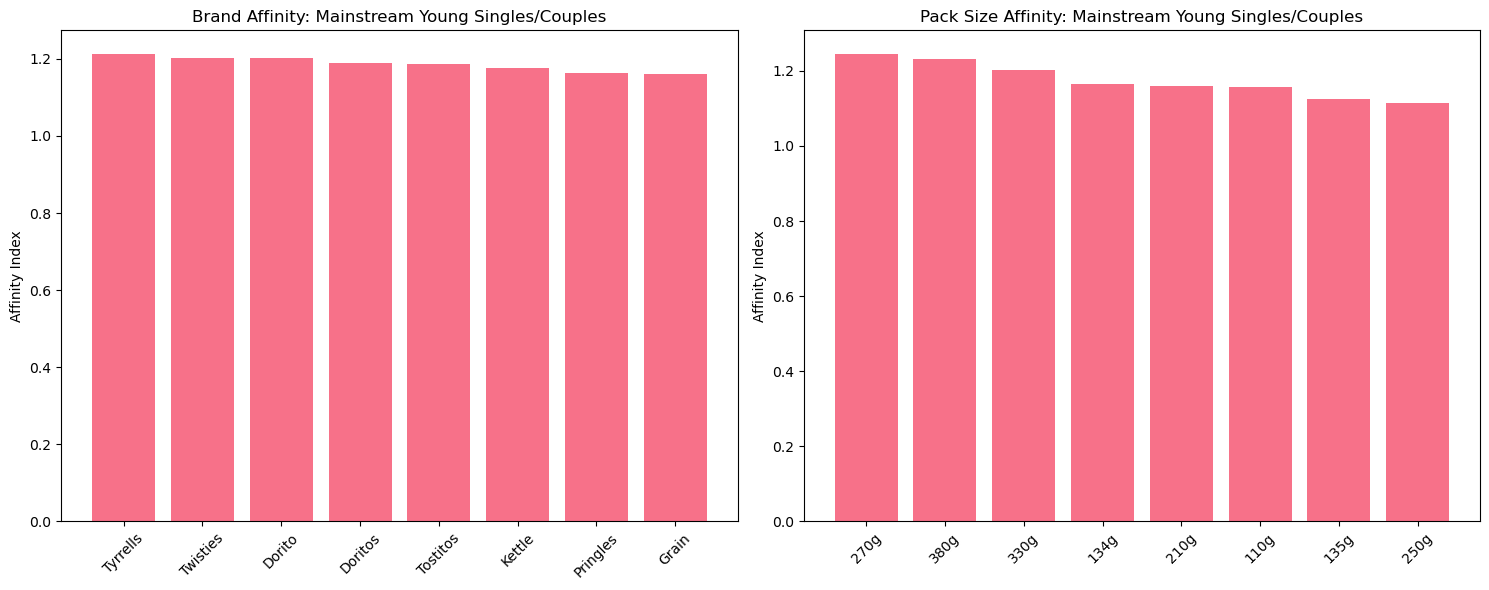

In [50]:
# Visualization of insights
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Brand preferences
top_brands = brand_comparison.head(8)
ax1.bar(range(len(top_brands)), top_brands['Affinity'])
ax1.set_xticks(range(len(top_brands)))
ax1.set_xticklabels(top_brands.index, rotation=45)
ax1.set_title('Brand Affinity: Mainstream Young Singles/Couples')
ax1.set_ylabel('Affinity Index')

# Pack size preferences  
top_packs = pack_comparison.head(8)
ax2.bar(range(len(top_packs)), top_packs['Affinity'])
ax2.set_xticks(range(len(top_packs)))
ax2.set_xticklabels([f"{int(x)}g" for x in top_packs.index], rotation=45)
ax2.set_title('Pack Size Affinity: Mainstream Young Singles/Couples')
ax2.set_ylabel('Affinity Index')

plt.tight_layout()
plt.show()